<a href="https://colab.research.google.com/github/akint980/Amazon-_Product_Review_Emotion_Analysis/blob/main/Tweetlens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Real data extracted from OpenDatabay and uploaded into Note

In [12]:
import pandas as pd

# Path to the downloaded CSV file
input_path = "/content/Amazon_Product_Queries_and_User_Reviews.csv"

# Load dataset
df = pd.read_csv(input_path)

# Inspect first few rows
print(df.head())




   qid                                              query     item_id  \
0    0  I need filters that effectively trap dust and ...  B0C5QYYHTJ   
1    1  I need to find a protein that is super healthy...  B0C7D3VLXW   
2    2  I need a pillow that helps keep my nasal pillo...  B0C3QRMPVN   
3    3  I need a memory stick that is excellent and ex...  B0BC13TQJQ   
4    4  I want to buy something that my children will ...  B07Z86PHP8   

                        user_id  ori_rating  \
0  AGREO2G3GTRNYOJK4CIQV2DTZLSQ           5   
1  AFLIZT24MDW4XG4HBYKOI3BZGDHQ           5   
2  AFCSK3W3GI7PGT4655HHKZ2CFFMA           5   
3  AGGOTCPWSQFI5YHNDLNZ63ABWZVA           5   
4  AEIIPB3DNXXLZX4VRCSVREXGCXUA           5   

                                          ori_review  
0  These filters work I could not believe the amo...  
1  Love We love this protein we’ve been using it ...  
2  CPAP help I use this pillow nightly with my CP...  
3  Excellent. More than expected Memory stick is ...  
4  

2. Data cleaned to remove duplicates, reviews shorter than 10 characters, nulls or empty reviews, URLs, conversion of texts to lower cases and removal of special characters.

In [21]:
import re

# Drop duplicates and nulls in 'ori_review' column
df.drop_duplicates(subset=['ori_review'], inplace=True)
df = df[df['ori_review'].notna()]

# Remove URLs
df['ori_review'] = df['ori_review'].apply(lambda x: re.sub(r'http\S+', '', str(x)))

# Lowercase (optional here since it’s already lowercase, but safe)
df['ori_review'] = df['ori_review'].str.lower()

# Remove special characters except alphanumeric and spaces
df['ori_review'] = df['ori_review'].apply(lambda x: re.sub(r'[^a-z0-9\s]', '', x))

# Remove short reviews
df = df[df['ori_review'].str.len() > 10]

print(df[['ori_review']].head())

df.to_csv("cleaned_amazon_queries_reviews.csv", index=False)



                                          ori_review
0  these filters work i could not believe the amo...
1  love we love this protein weve been using it f...
2  cpap help i use this pillow nightly with my cp...
3  excellent more than expected memory stick is g...
4  my children love these my son asked me to purc...


3.Data info

In [18]:
df.info()





<class 'pandas.core.frame.DataFrame'>
Index: 21222 entries, 0 to 21222
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   qid         21222 non-null  int64 
 1   query       21222 non-null  object
 2   item_id     21222 non-null  object
 3   user_id     21222 non-null  object
 4   ori_rating  21222 non-null  int64 
 5   ori_review  21222 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


4. Sentiment analysis on Amazon queries

In [42]:
'''import pandas as pd
from textblob import TextBlob

# Load your dataset
df = pd.read_csv("cleaned_amazon_queries_reviews.csv")  # your cleaned CSV

# Define a function to get sentiment polarity
def get_sentiment(text):
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Negative"

# Apply sentiment function to the review column (adjust column name)
df['Sentiment'] = df['ori_review'].apply(get_sentiment)

# See results
print(df[['ori_review', 'Sentiment']].head())

# Save results to new CSV
df.to_csv("amazon_queries_reviews_sentiment.csv", index=False)'''



Index(['qid', 'query', 'item_id', 'user_id', 'ori_rating', 'ori_review',
       'trimmed_review', 'emotion'],
      dtype='object')


5. Emotional Analysis of Amazon query reviews

In [30]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F

# Load the model and tokenizer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Load your cleaned review dataset
df = pd.read_csv("cleaned_amazon_queries_reviews.csv")

# Optionally trim overly long reviews (safety step)
df['trimmed_review'] = df['ori_review'].apply(lambda x: ' '.join(str(x).split()[:300]))

# Get the label names (from model config)
labels = model.config.id2label

# Define emotion detection function
def get_emotion(text):
    try:
        # Tokenize input with truncation
        tokens = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")

        # Run the model
        with torch.no_grad():
            outputs = model(**tokens)

        # Get probabilities via softmax
        probs = F.softmax(outputs.logits, dim=1)

        # Get highest-scoring label
        predicted_label_idx = torch.argmax(probs, dim=1).item()
        return labels[predicted_label_idx]
    except Exception as e:
        print(f"Error on text: {text[:100]}...\n{e}")
        return "unknown"

# Apply to reviews
df['emotion'] = df['trimmed_review'].apply(get_emotion)

# Save to CSV
df.to_csv("amazon_reviews_with_emotion.csv", index=False)

# Preview
print(df[['ori_review', 'emotion']].head())


                                          ori_review   emotion
0  these filters work i could not believe the amo...  surprise
1  love we love this protein weve been using it f...       joy
2  cpap help i use this pillow nightly with my cp...       joy
3  excellent more than expected memory stick is g...       joy
4  my children love these my son asked me to purc...       joy


6. Visualization

/tmp/ipython-input-2344533145.py:29: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2344533145.py:29: UserWarning: Glyph 127998 (\N{EMOJI MODIFIER FITZPATRICK TYPE-5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2344533145.py:29: UserWarning: Glyph 129392 (\N{SMILING FACE WITH SMILING EYES AND THREE HEARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2344533145.py:29: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2344533145.py:29: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2344533145.py:29: UserWarning: Glyph 129303 (\N{HUGGING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2344533145.py:29: UserWarning: Tight layout not applied. The left and

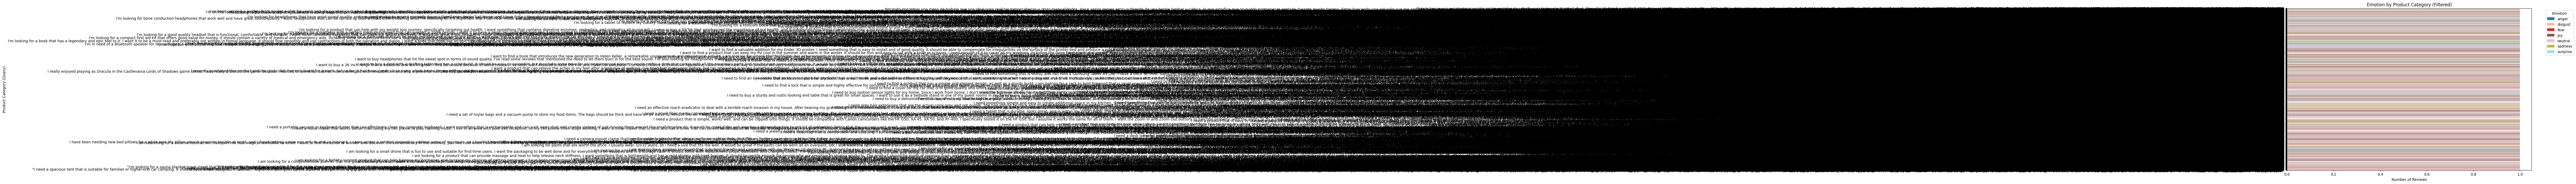

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Load CSV into DataFrame
file_path = '/content/amazon_reviews_with_emotion.csv'  # Change this to your actual file path
df = pd.read_csv(file_path)

# Step 2: Filter out rows where 'query' contains the phrase 'BAD A$$'
filtered_df = df[~df['query'].str.contains(r'bad a\$\$', case=False, na=False)]

# Step 3: Group by 'query' and 'emotion' and count occurrences
emotion_by_query = filtered_df.groupby(['query', 'emotion']).size().reset_index(name='count')

# Pivot for stacked chart
pivot = emotion_by_query.pivot(index='query', columns='emotion', values='count').fillna(0)

# Step 4: Plot horizontal stacked bar chart
pivot.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20',
    title="Emotion by Product Category (Filtered)"
)

plt.xlabel("Number of Reviews")
plt.ylabel("Product Category (Query)")
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Sentiment Analysis visualization

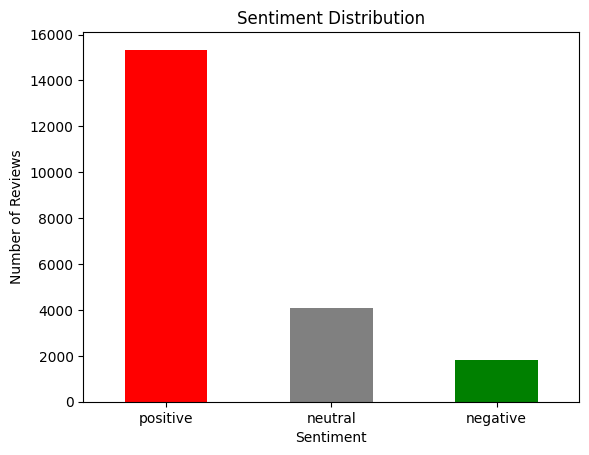

In [43]:
import matplotlib.pyplot as plt

# Example mapping of emotions to sentiments
emotion_to_sentiment = {
    'anger': 'negative',
    'disgust': 'negative',
    'fear': 'negative',
    'sadness': 'negative',
    'joy': 'positive',
    'surprise': 'positive',
    'neutral': 'neutral'
}

# Assuming your dataframe is named df
df['sentiment'] = df['emotion'].map(emotion_to_sentiment)

# Count the number of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Plot sentiment distribution
sentiment_counts.plot(kind='bar', color=['red', 'gray', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()



/tmp/ipython-input-2530681455.py:47: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


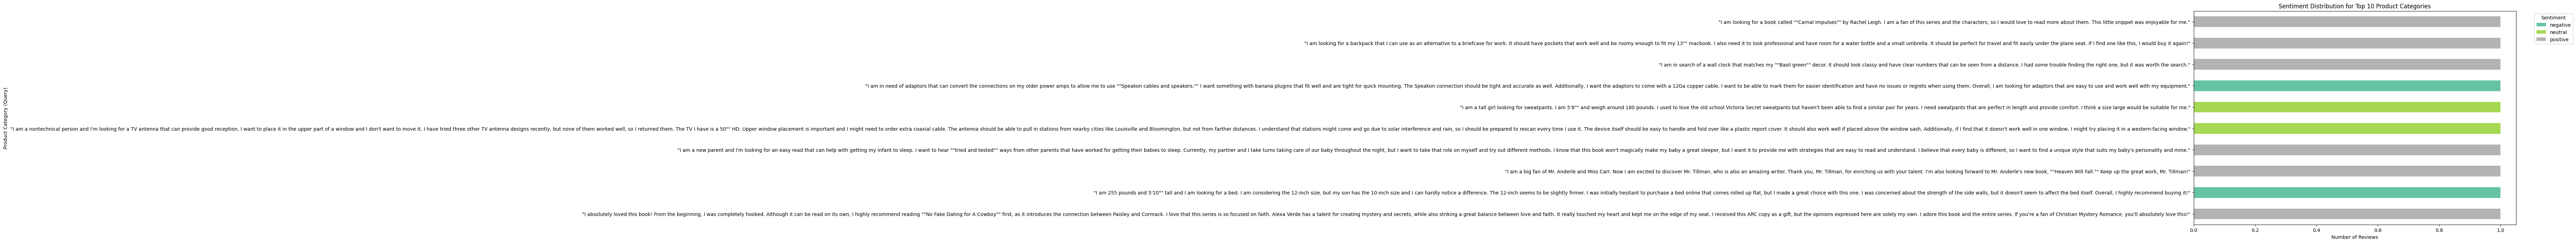

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('amazon_reviews_with_emotion.csv')

# Map emotions to sentiment
emotion_to_sentiment = {
    'joy': 'positive',
    'surprise': 'positive',
    'anger': 'negative',
    'disgust': 'negative',
    'fear': 'negative',
    'sadness': 'negative',
    'neutral': 'neutral'
}
df['sentiment'] = df['emotion'].map(emotion_to_sentiment)

# Group by product category and sentiment to count reviews
sentiment_by_query = df.groupby(['query', 'sentiment']).size().reset_index(name='count')

# Calculate total reviews per product category
total_reviews = df.groupby('query').size().reset_index(name='total_count')

# Select top N categories by total review count
top_n = 10
top_categories = total_reviews.nlargest(top_n, 'total_count')['query']

# Filter sentiment data for top categories only
filtered_sentiment = sentiment_by_query[sentiment_by_query['query'].isin(top_categories)]

# Pivot for plotting
pivot = filtered_sentiment.pivot(index='query', columns='sentiment', values='count').fillna(0)

# Plot
pivot.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
    colormap='Set2',
    title=f'Sentiment Distribution for Top {top_n} Product Categories'
)

plt.xlabel('Number of Reviews')
plt.ylabel('Product Category (Query)')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
